## Import Library and Load Data
X = 4, Y = Price

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import make_scorer,mean_squared_log_error
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [52]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [54]:
df.drop(columns=['id','date'],inplace=True)

In [55]:
df.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [56]:
df.duplicated().sum()

5

In [57]:
df = df.drop_duplicates()

## Handle Outliers

In [58]:
Continuous = ['price','sqft_living','sqft_lot','sqft_basement','sqft_above','yr_built','zipcode','lat', 'long', 'sqft_living15', 'sqft_lot15']
categorical = ['bedrooms', 'bathrooms','floors','waterfront', 'view', 'condition', 'grade']

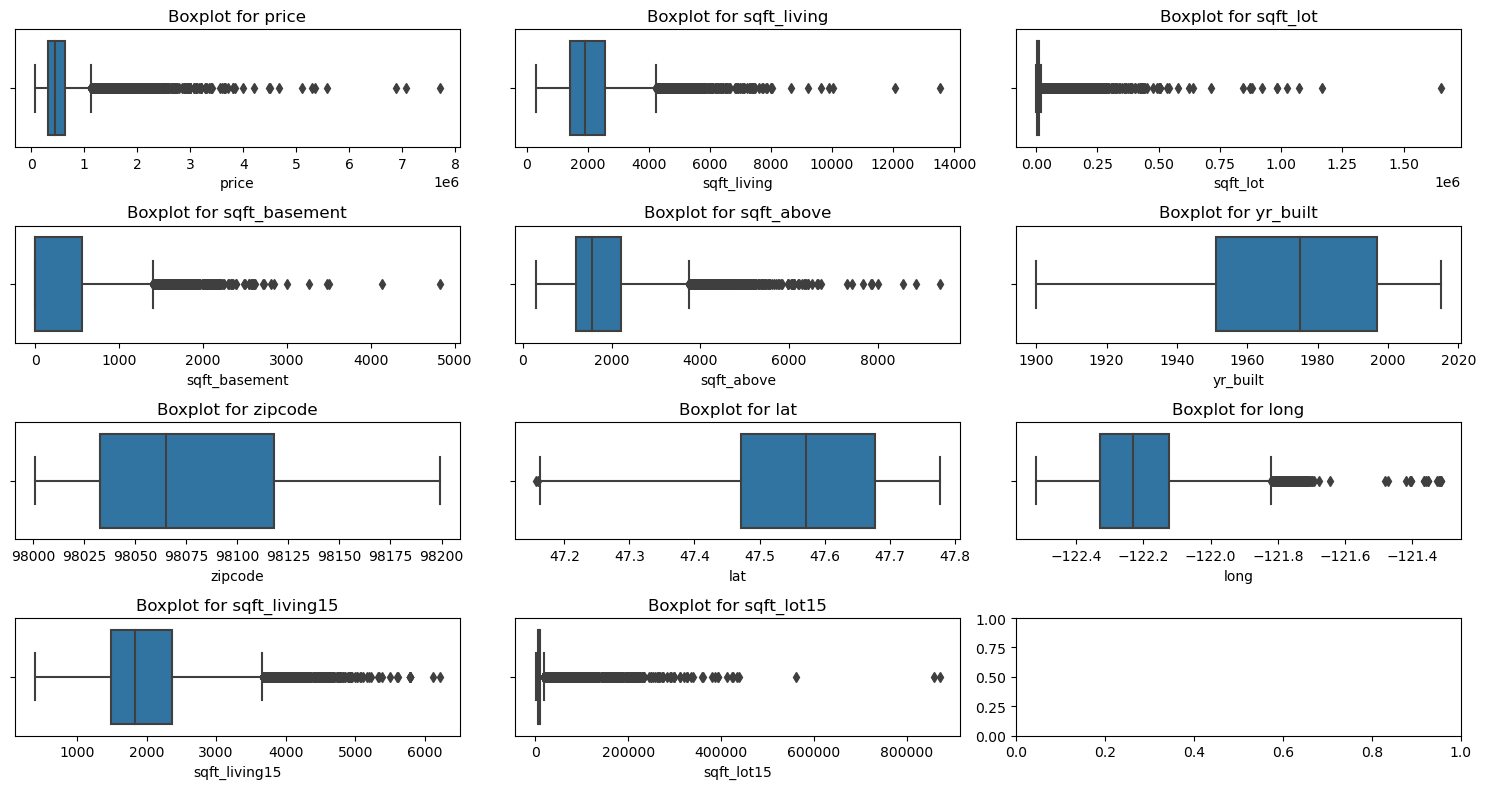

In [59]:
num_cols = len(Continuous)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,8))

for i, column in enumerate(Continuous):
  row = i // 3
  col = i % 3
  ax = axes[row, col]
  sns.boxplot(x=column, data=df, ax=axes[row, col])
  axes[row, col].set_title(f'Boxplot for {column}')


plt.tight_layout()
plt.show()

In [60]:
outlier_col = ['price','sqft_living','sqft_lot','sqft_lot15','sqft_basement','sqft_living15','sqft_above']

In [61]:
df_new = df
for i in range(2):
  for i in outlier_col:
    percentile25 = df_new[i].quantile(0.25)
    percentile75 = df_new[i].quantile(0.75)
    iqr = percentile75 - percentile25

    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr

    df_new = df_new[df_new[i] < upper_limit]

In [62]:
df_new = df_new.drop(columns='yr_renovated')

In [63]:
df_new = df_new.reset_index(drop=True)

<Axes: >

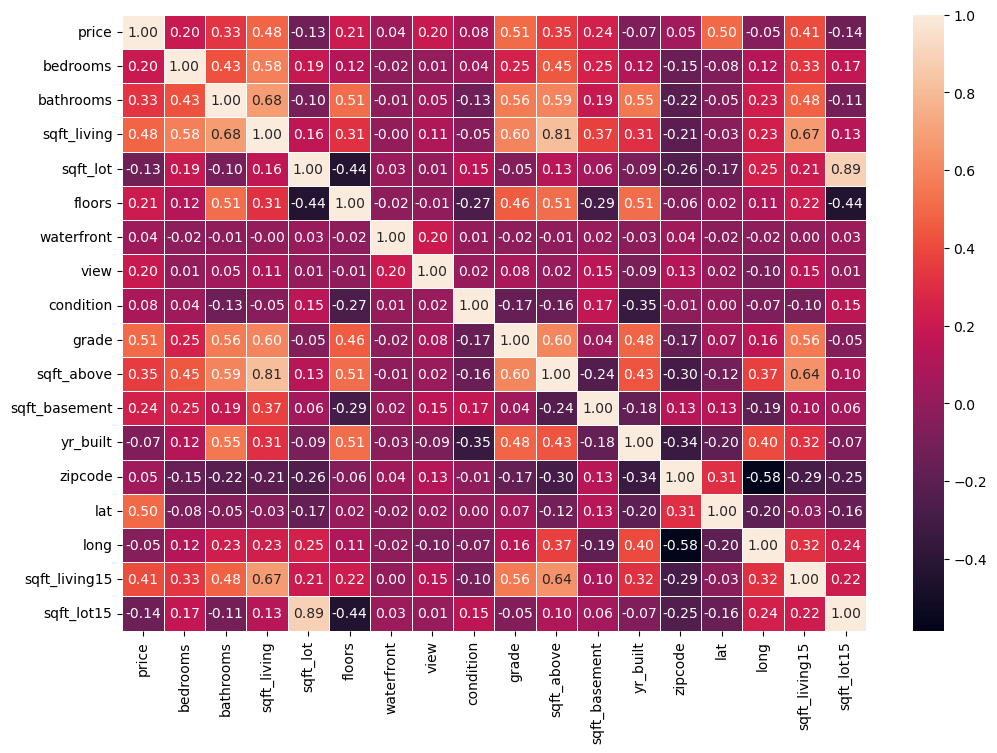

In [64]:
# corr = df_new.corr()

# sns.heatmap(df_new.corr(), annot=True)

plt.figure(figsize=(12, 8))
sns.heatmap(df_new.corr(), annot=True, fmt='.2f', linewidths=0.5)

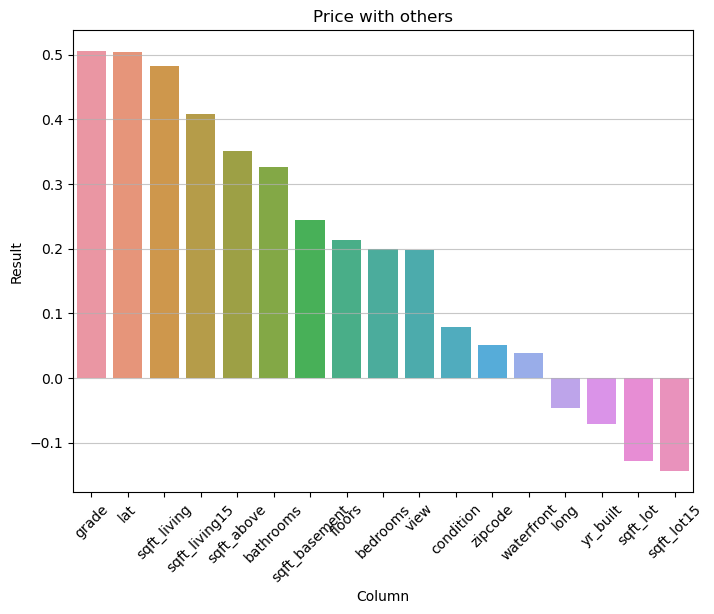

In [65]:
corr_matrix = df_new.corr()

corr_price = corr_matrix['price'].drop('price').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_price.index, y=corr_price.values)

plt.xlabel('Column')
plt.ylabel('Result')
plt.title('Price with others')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.7)

plt.show()

In [66]:
df_new = df_new[['grade', 'lat', 'sqft_living', 'sqft_living15', 'price']]

In [67]:
X = df_new.drop(columns='price')
y = df_new['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [68]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_scaled = sc.transform(X)

In [69]:
lr_reg = LinearRegression()
lr_reg.fit(X_train_scaled, y_train)
y_pred = lr_reg.predict(X_test_scaled)

print('training',np.mean(cross_val_score(lr_reg, X_train, y_train, cv=5, scoring='r2')))
print('testing',np.mean(cross_val_score(lr_reg, X_test, y_test, cv=5, scoring='r2')))

training 0.5493851974098511
testing 0.5623175411833189


### Linearity

In [70]:
y_pred = lr_reg.predict(X_scaled)
residuals = y - y_pred

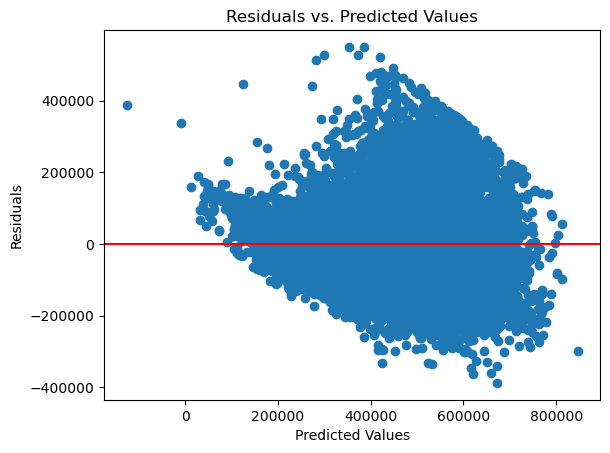

In [71]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.show()

Residualnya acak di sekitar nol yang berarti data aur adalah linier

## Normality Of Residuals

#### 1) Histogram/Q-Q plot

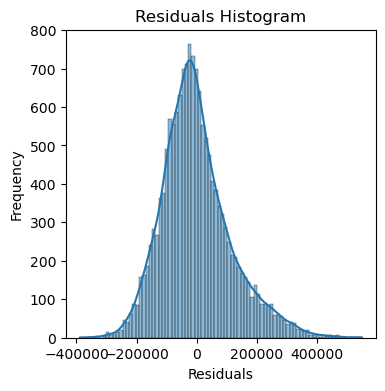

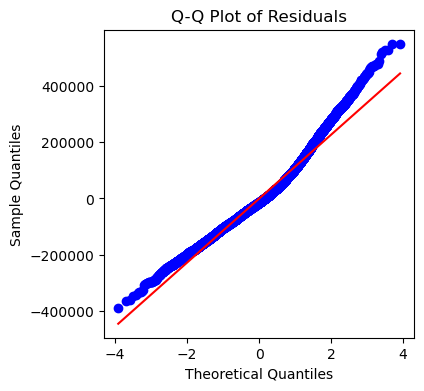

In [72]:
plt.figure(figsize=(4, 4))
sns.histplot(residuals, kde=True)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

from scipy import stats

plt.figure(figsize=(4, 4))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [73]:
mean_residuals = np.mean(residuals)
print(f'Mean of residuals: {mean_residuals:.4f}')

Mean of residuals: -412.3333


## Homoscedasicity

### Breusch-Pagan test


In [74]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
x_with_constant1 = sm.add_constant(X)
model1 = sm.OLS(y, x_with_constant1).fit()
bp_test1 = het_breuschpagan(model1.resid, x_with_constant1)
print('Homoscedastic dataset - Breusch-Pagan test results:')
print(f'LM Statistic: {bp_test1[0]}\nLM-Test p-value: {bp_test1[1]}\nF-Statistic: {bp_test1[2]}\nF-Test p-value: {bp_test1[3]}\n')


Homoscedastic dataset - Breusch-Pagan test results:
LM Statistic: 1292.105372792844
LM-Test p-value: 1.7132586133143323e-278
F-Statistic: 352.62498068487287
F-Test p-value: 6.356001766847842e-291



## Multicolinearity

In [75]:
import statsmodels.api as sm

In [76]:
XX = sm.add_constant(X_scaled)
model = sm.OLS(y, XX).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     4739.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:22:40   Log-Likelihood:            -2.0052e+05
No. Observations:               15339   AIC:                         4.011e+05
Df Residuals:                   15334   BIC:                         4.011e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.308e+05    929.821    463.271      0.0

## Train

In [77]:
sc = StandardScaler()
df_new_scaled = sc.fit_transform(df_new)
df_new_scaled = pd.DataFrame(df_new_scaled)

In [78]:
X = df_new.drop(columns=['price'])
y = df_new['price']

In [79]:
X_scaled = sc.fit_transform(X)
XX = sm.add_constant(X_scaled)
model = sm.OLS(y, XX).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     4739.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        20:22:40   Log-Likelihood:            -2.0052e+05
No. Observations:               15339   AIC:                         4.011e+05
Df Residuals:                   15334   BIC:                         4.011e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.303e+05    929.809    462.819      0.0

In [80]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [81]:
X_train.columns

Index(['grade', 'lat', 'sqft_living', 'sqft_living15'], dtype='object')

In [82]:
test = [[7, 47.5208, 1360, 5000]]
output = model.predict(test)
print('Price : ', output)

Price :  [462009.62037262]


In [83]:
test = [[6, 67.5208, 1200, 6700,]]
output = model.predict(test)
print('Price : ', output)


Price :  [12706958.86530849]


In [84]:
X_test

,grade,lat,sqft_living,sqft_living15
7882,6,47.5559,800,1090
5375,8,47.6391,1470,1760
9228,8,47.4406,2430,2070
927,7,47.7683,1570,1570
5996,7,47.5072,1630,1270
...,...,...,...,...
573,8,47.5433,2390,2140
6498,7,47.5403,2170,2440
7332,7,47.6923,980,1470
4800,7,47.4661,1850,2160


In [85]:
y_pred = model.predict(X_test)

In [86]:
y_pred

array([256777.93971874, 491826.0255447 , 467825.46893336, ...,
       419665.50852546, 382597.3916548 , 581483.04369268])

In [87]:
y_test

7882     388000.0
5375     865000.0
9228     330000.0
927      360000.0
5996     236000.0
           ...   
573      565000.0
6498     443500.0
7332     463800.0
4800     299000.0
11216    670000.0
Name: price, Length: 3068, dtype: float64

In [88]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R Squared Score is:', r2_score(y_test, y_pred))

Mean Absolute Error: 85164.91146023727
Mean Squared Error: 12494351322.829065
R Squared Score is: 0.5648277152066279


In [89]:
from sklearn import linear_model
model = linear_model.Ridge(alpha=.5)

model.fit(X_train, y_train)

# evaluasi

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R Squared Score is:', r2_score(y_test, y_pred))

Mean Absolute Error: 85164.91146023727
Mean Squared Error: 12494351322.829065
R Squared Score is: 0.5648277152066279
